In [1]:
import os
import sys
import inspect

# Insert modules directory, TODO create setup.py file
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
reports_dir = os.path.dirname(currentdir)
project_home_dir = os.path.dirname(reports_dir)
sys.path.insert(0, f"{project_home_dir}/qcnn")

In [2]:
import numpy as np
import pandas as pd
from pprint import pprint
from reporting_functions import (
    get_file_content,
    get_result_table,
    get_result_table_target_pairs,
)
from joblib import dump, load
from collections import namedtuple

In [3]:
experiments_path = f"{project_home_dir}/experiments"
experiment_filename = "experiment.json"
target_levels = [
    "classical",
    "country",
    "rock",
    "pop",
    "hiphop",
    "jazz",
    "blues",
    "disco",
    "metal",
    "reggae",
]

In [4]:
experiment_id = 114
experiment_config = get_file_content(
    f"{experiments_path}/{experiment_id}/{experiment_filename}"
)

In [5]:
pprint(experiment_config)

{'ID': 114,
 'data': {'path': '/home/matt/dev/projects/quantum-cnn/data/archive/Data/features_30_sec.csv',
          'sampling': {'random_state': 42, 'test_size': 0.3},
          'target_column': 'label',
          'target_pairs': [['classical', 'country'],
                           ['classical', 'rock'],
                           ['classical', 'pop'],
                           ['classical', 'hiphop'],
                           ['classical', 'jazz'],
                           ['classical', 'blues'],
                           ['classical', 'disco'],
                           ['classical', 'metal'],
                           ['classical', 'reggae'],
                           ['country', 'rock'],
                           ['country', 'pop'],
                           ['country', 'hiphop'],
                           ['country', 'jazz'],
                           ['country', 'blues'],
                           ['country', 'disco'],
                           ['country', 'metal

In [6]:
path = f"{experiment_config.get('path')}/{experiment_config.get('ID')}"

In [7]:
y_test = pd.read_csv(f"{path}/y_test.csv", index_col=0)

In [8]:
model_names = [
    filename.split("-model_configuration.joblib")[0]
    for filename in os.listdir(path)
    if "-model_configuration.joblib" in filename
]

In [9]:
# Gather results
Results = namedtuple(
    "Results", ["model_name", "y_test_hat", "clf", "model_configuration", "samples_tfd"]
)
result_list = []
for model_name in model_names:
    y_test_hat = pd.read_csv(f"{path}/{model_name}-yhat.csv", index_col=0)
    clf = load(f"{path}/{model_name}-clf_results.joblib")
    model_configuration = load(f"{path}/{model_name}-model_configuration.joblib")
    samples_tfd = load(f"{path}/{model_name}-samples_tfd.joblib")
    result_list = result_list + [
        Results(
            model_name,
            y_test_hat=y_test_hat,
            clf=clf,
            model_configuration=model_configuration,
            samples_tfd=samples_tfd,
        )
    ]
print(len(result_list))

720


In [10]:
# Table
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

result_data = pd.DataFrame(
    {
        "model_name": [],
        "model_type": [],
        "algorithm": [],
        "classification_type": [],
        "embedding_type": [],
        "scaler_method": [],
        "scaler_param_str": [],
        "selection_method": [],
        "selection_param_str": [],
        "target_pair": [],
        "additional_structure": [],
        "target_pair_str": [],
        "mean_test_score": [],
        "std_test_score": [],
        "params": [],
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "loss_train_history": [],
    }
)
for result in result_list:
    y_test_hat = result.y_test_hat
    clf = result.clf
    model_configuration = result.model_configuration
    samples_tfd = result.samples_tfd
    model_name = result.model_name

    precision, recall, fscore, support = precision_recall_fscore_support(
        samples_tfd.y_test, y_test_hat, average="binary"  # TODO multiclass
    )
    accuracy = accuracy_score(samples_tfd.y_test, y_test_hat)
    tmp_result = model_configuration._asdict()
    tmp_result["model_name"] = model_name

    tmp_result["target_pair_str"] = "_".join(model_configuration.target_pair)
    tmp_result["mean_test_score"] = clf.cv_results_["mean_test_score"][clf.best_index_]
    tmp_result["std_test_score"] = clf.cv_results_["std_test_score"][clf.best_index_]
    tmp_result["params"] = clf.cv_results_["params"][clf.best_index_]

    tmp_result["accuracy"] = accuracy
    tmp_result["precision"] = precision
    tmp_result["recall"] = recall
    tmp_result["f1"] = fscore
    tmp_result["loss_train_history"] = None  # set for quantum
    result_data = result_data.append(tmp_result, ignore_index=True)

In [11]:
result_data.head()

,model_name,model_type,algorithm,classification_type,embedding_type,scaler_method,scaler_param_str,selection_method,selection_param_str,target_pair,additional_structure,target_pair_str,mean_test_score,std_test_score,params,accuracy,precision,recall,f1,loss_train_history
0,classical-svm-binary-normal-minmax-n_component...,classical,svm,binary,normal,minmax,n_components=8,pca,"feature_range=[0, 1.5707963267948966]","[classical, reggae]",None,classical_reggae,0.973333,0.024944,"{'C': 0.5, 'kernel': 'rbf'}",0.979592,1.000000,0.965517,0.982456,None
1,classical-svm-binary-normal-standard-n_compone...,classical,svm,binary,normal,standard,n_components=8,pca,,"[hiphop, jazz]",None,hiphop_jazz,1.000000,0.000000,"{'C': 0.5, 'kernel': 'rbf'}",0.947368,0.968750,0.939394,0.953846,None
2,classical-svm-binary-normal-minmax-max_feature...,classical,svm,binary,normal,minmax,max_features=8_n_estimators=50,tree,"feature_range=[0, 1]","[country, metal]",None,country_metal,0.992593,0.014815,"{'C': 10, 'kernel': 'linear'}",0.940299,0.906250,0.966667,0.935484,None
3,classical-logistic_regression-binary-normal-mi...,classical,logistic_regression,binary,normal,minmax,n_components=8,pca,"feature_range=[0, 1]","[pop, disco]",None,pop_disco,0.852956,0.059846,"{'C': 10.0, 'penalty': 'l2'}",0.877193,0.935484,0.852941,0.892308,None
4,classical-logistic_regression-binary-normal-mi...,classical,logistic_regression,binary,normal,minmax,n_components=8,pca,"feature_range=[0, 1.5707963267948966]","[country, hiphop]",None,country_hiphop,0.942328,0.036644,"{'C': 10.0, 'penalty': 'l2'}",0.967213,0.923077,1.000000,0.960000,None


In [12]:
a=get_result_table(
    result_data,
    ["algorithm", "selection_method", "scaler_method", "target_pair_str"],
    "accuracy",
)

In [16]:
a.columns

Index(['blues_disco', 'blues_metal', 'blues_reggae', 'classical_blues',
       'classical_country', 'classical_disco', 'classical_hiphop',
       'classical_jazz', 'classical_metal', 'classical_pop',
       'classical_reggae', 'classical_rock', 'country_blues', 'country_disco',
       'country_hiphop', 'country_jazz', 'country_metal', 'country_pop',
       'country_reggae', 'country_rock', 'disco_metal', 'disco_reggae',
       'hiphop_blues', 'hiphop_disco', 'hiphop_jazz', 'hiphop_metal',
       'hiphop_reggae', 'jazz_blues', 'jazz_disco', 'jazz_metal',
       'jazz_reggae', 'metal_reggae', 'pop_blues', 'pop_disco', 'pop_hiphop',
       'pop_jazz', 'pop_metal', 'pop_reggae', 'rock_blues', 'rock_disco',
       'rock_hiphop', 'rock_jazz', 'rock_metal', 'rock_pop', 'rock_reggae',
       'algorithm Average'],
      dtype='object', name='target_pair_str')

In [20]:
a["rock_reggae"]

(logistic_regression, pca, minmax)       0.828125
(logistic_regression, pca, standard)     0.812500
(logistic_regression, tree, minmax)      0.817708
(logistic_regression, tree, standard)    0.828125
(svm, pca, minmax)                       0.843750
(svm, pca, standard)                     0.828125
(svm, tree, minmax)                      0.786458
(svm, tree, standard)                    0.765625
selection_method Average                 0.813802
Name: rock_reggae, dtype: float64

In [13]:
get_result_table(
    result_data,
    ["algorithm", "selection_method", "scaler_method", "target_pair_str"],
    "mean_test_score",
)

target_pair_str,blues_disco,blues_metal,blues_reggae,classical_blues,classical_country,classical_disco,classical_hiphop,classical_jazz,classical_metal,classical_pop,...,pop_metal,pop_reggae,rock_blues,rock_disco,rock_hiphop,rock_jazz,rock_metal,rock_pop,rock_reggae,algorithm Average
"(logistic_regression, pca, minmax)",0.885375,0.906173,0.923721,0.977011,0.964778,0.986207,1.000000,0.922529,1.0,0.993750,...,0.993103,0.899004,0.825641,0.717569,0.929557,0.919183,0.903704,0.913383,0.906702,0.919672
"(logistic_regression, pca, standard)",0.923362,0.903704,0.911640,0.979310,0.979064,0.986207,1.000000,0.917931,1.0,0.993750,...,0.993103,0.885517,0.838462,0.724786,0.922414,0.893732,0.903704,0.915764,0.882540,0.916034
"(logistic_regression, tree, minmax)",0.921273,0.938272,0.894268,0.983908,0.941790,0.974713,0.991398,0.888276,1.0,0.982863,...,0.993103,0.886130,0.846154,0.768566,0.933826,0.875878,0.906173,0.913629,0.904056,0.922609
"(logistic_regression, tree, standard)",0.938746,0.948148,0.919048,0.972414,0.950985,0.979310,0.987097,0.890345,1.0,0.987097,...,0.993103,0.879310,0.792308,0.771795,0.935961,0.878348,0.903704,0.908374,0.918783,0.921581
"(svm, pca, minmax)",0.915385,0.911111,0.941005,0.988506,0.976683,0.986207,1.000000,0.945057,1.0,0.987500,...,0.993103,0.889962,0.884615,0.763818,0.943103,0.908927,0.916049,0.911248,0.911376,0.932083
"(svm, pca, standard)",0.930769,0.903704,0.941005,0.979310,0.978818,0.979310,1.000000,0.931494,1.0,0.993750,...,0.993103,0.872414,0.900000,0.771510,0.929064,0.901425,0.933333,0.922660,0.889683,0.929315
"(svm, tree, minmax)",0.921178,0.930864,0.916402,0.986207,0.958046,0.979310,0.985013,0.924904,1.0,0.987164,...,0.993103,0.879157,0.823077,0.804558,0.940805,0.894207,0.933333,0.925287,0.908907,0.932240
"(svm, tree, standard)",0.923647,0.940741,0.896825,0.979310,0.951232,0.986207,0.987097,0.945287,1.0,0.987097,...,0.986207,0.885977,0.861538,0.816809,0.936207,0.848148,0.918519,0.936946,0.911376,0.934268
selection_method Average,0.919967,0.922840,0.917989,0.980747,0.962674,0.982184,0.993826,0.920728,1.0,0.989121,...,0.992241,0.884684,0.846474,0.767426,0.933867,0.889981,0.914815,0.918411,0.904178,0.925975


In [14]:
get_result_table(
    result_data,
    ["algorithm", "selection_method", "scaler_method", "target_pair_str"],
    "std_test_score",
)

target_pair_str,blues_disco,blues_metal,blues_reggae,classical_blues,classical_country,classical_disco,classical_hiphop,classical_jazz,classical_metal,classical_pop,...,pop_metal,pop_reggae,rock_blues,rock_disco,rock_hiphop,rock_jazz,rock_metal,rock_pop,rock_reggae,algorithm Average
"(logistic_regression, pca, minmax)",0.055815,0.037771,0.054865,0.019864,0.031404,0.016893,0.000000,0.055370,0.0,0.012500,...,0.013793,0.072441,0.066785,0.078517,0.058605,0.051112,0.018144,0.043460,0.044399,0.040457
"(logistic_regression, pca, standard)",0.059771,0.037771,0.055583,0.016893,0.027713,0.016893,0.000000,0.047155,0.0,0.012500,...,0.013793,0.100238,0.044853,0.083157,0.068360,0.051271,0.055432,0.051563,0.035477,0.042855
"(logistic_regression, tree, minmax)",0.042048,0.034563,0.064723,0.016893,0.040282,0.026398,0.013870,0.059097,0.0,0.025774,...,0.013793,0.087403,0.058416,0.061383,0.045759,0.059271,0.043370,0.052444,0.041350,0.040124
"(logistic_regression, tree, standard)",0.019196,0.029630,0.043296,0.025805,0.042379,0.027586,0.015803,0.067414,0.0,0.015803,...,0.013793,0.100094,0.057564,0.103330,0.052625,0.057134,0.037771,0.028614,0.036615,0.042318
"(svm, pca, minmax)",0.066172,0.044444,0.050359,0.015860,0.025345,0.016893,0.000000,0.060204,0.0,0.025000,...,0.013793,0.073151,0.048650,0.072576,0.042983,0.054832,0.034069,0.059695,0.044755,0.039543
"(svm, pca, standard)",0.070501,0.055432,0.044580,0.016893,0.028452,0.027586,0.000000,0.038196,0.0,0.012500,...,0.013793,0.089999,0.052172,0.098637,0.022609,0.052203,0.054433,0.059458,0.023478,0.040801
"(svm, tree, minmax)",0.042373,0.043366,0.055609,0.016893,0.033630,0.027586,0.015722,0.044875,0.0,0.019056,...,0.013793,0.098187,0.043181,0.079670,0.035979,0.056166,0.040255,0.048126,0.049841,0.039138
"(svm, tree, standard)",0.048664,0.037771,0.075756,0.016893,0.041637,0.016893,0.025806,0.034997,0.0,0.025806,...,0.016893,0.080063,0.039223,0.088967,0.026612,0.054263,0.054433,0.040826,0.044755,0.038968
selection_method Average,0.050567,0.040093,0.055596,0.018249,0.033855,0.022091,0.008900,0.050913,0.0,0.018617,...,0.014181,0.087697,0.051356,0.083280,0.044192,0.054531,0.042238,0.048023,0.040084,0.040526


In [15]:
get_result_table_target_pairs(result_data, "algorithm", "target_pair_str", "accuracy")

,metal,disco,blues,classical,country,hiphop,jazz,rock,reggae,pop,Average
metal,NaN,0.921875,0.907692,1.0,0.955224,0.962963,0.984127,0.861538,0.966102,1.0,0.951058
disco,0.921875,NaN,0.869565,1.0,0.873239,0.810345,0.955224,0.782609,0.825397,0.929825,0.885342
blues,0.907692,0.869565,NaN,1.0,0.861111,1.0,0.941176,0.8,0.890625,1.0,0.918908
classical,1.0,1.0,1.0,NaN,0.982456,1.0,0.962264,1.0,1.0,1.0,0.993858
country,0.955224,0.873239,0.861111,0.982456,NaN,0.967213,0.942857,0.763889,0.893939,0.95,0.909992
hiphop,0.962963,0.810345,1.0,1.0,0.967213,NaN,1.0,0.932203,0.792453,0.978723,0.938211
jazz,0.984127,0.955224,0.941176,0.962264,0.942857,1.0,NaN,0.926471,0.951613,0.982143,0.960653
rock,0.861538,0.782609,0.8,1.0,0.763889,0.932203,0.926471,NaN,0.84375,0.948276,0.873193
reggae,0.966102,0.825397,0.890625,1.0,0.893939,0.792453,0.951613,0.84375,NaN,0.942308,0.900687
pop,1.0,0.929825,1.0,1.0,0.95,0.978723,0.982143,0.948276,0.942308,NaN,0.970142


In [337]:
genre = "rock"
filtered_results = [
    result
    for result in result_list
    if result.model_configuration.target_pair == ["rock", "reggae"]
]
# filtered_results = [
#     result for result in result_list if genre in result.model_configuration.target_pair
# ]

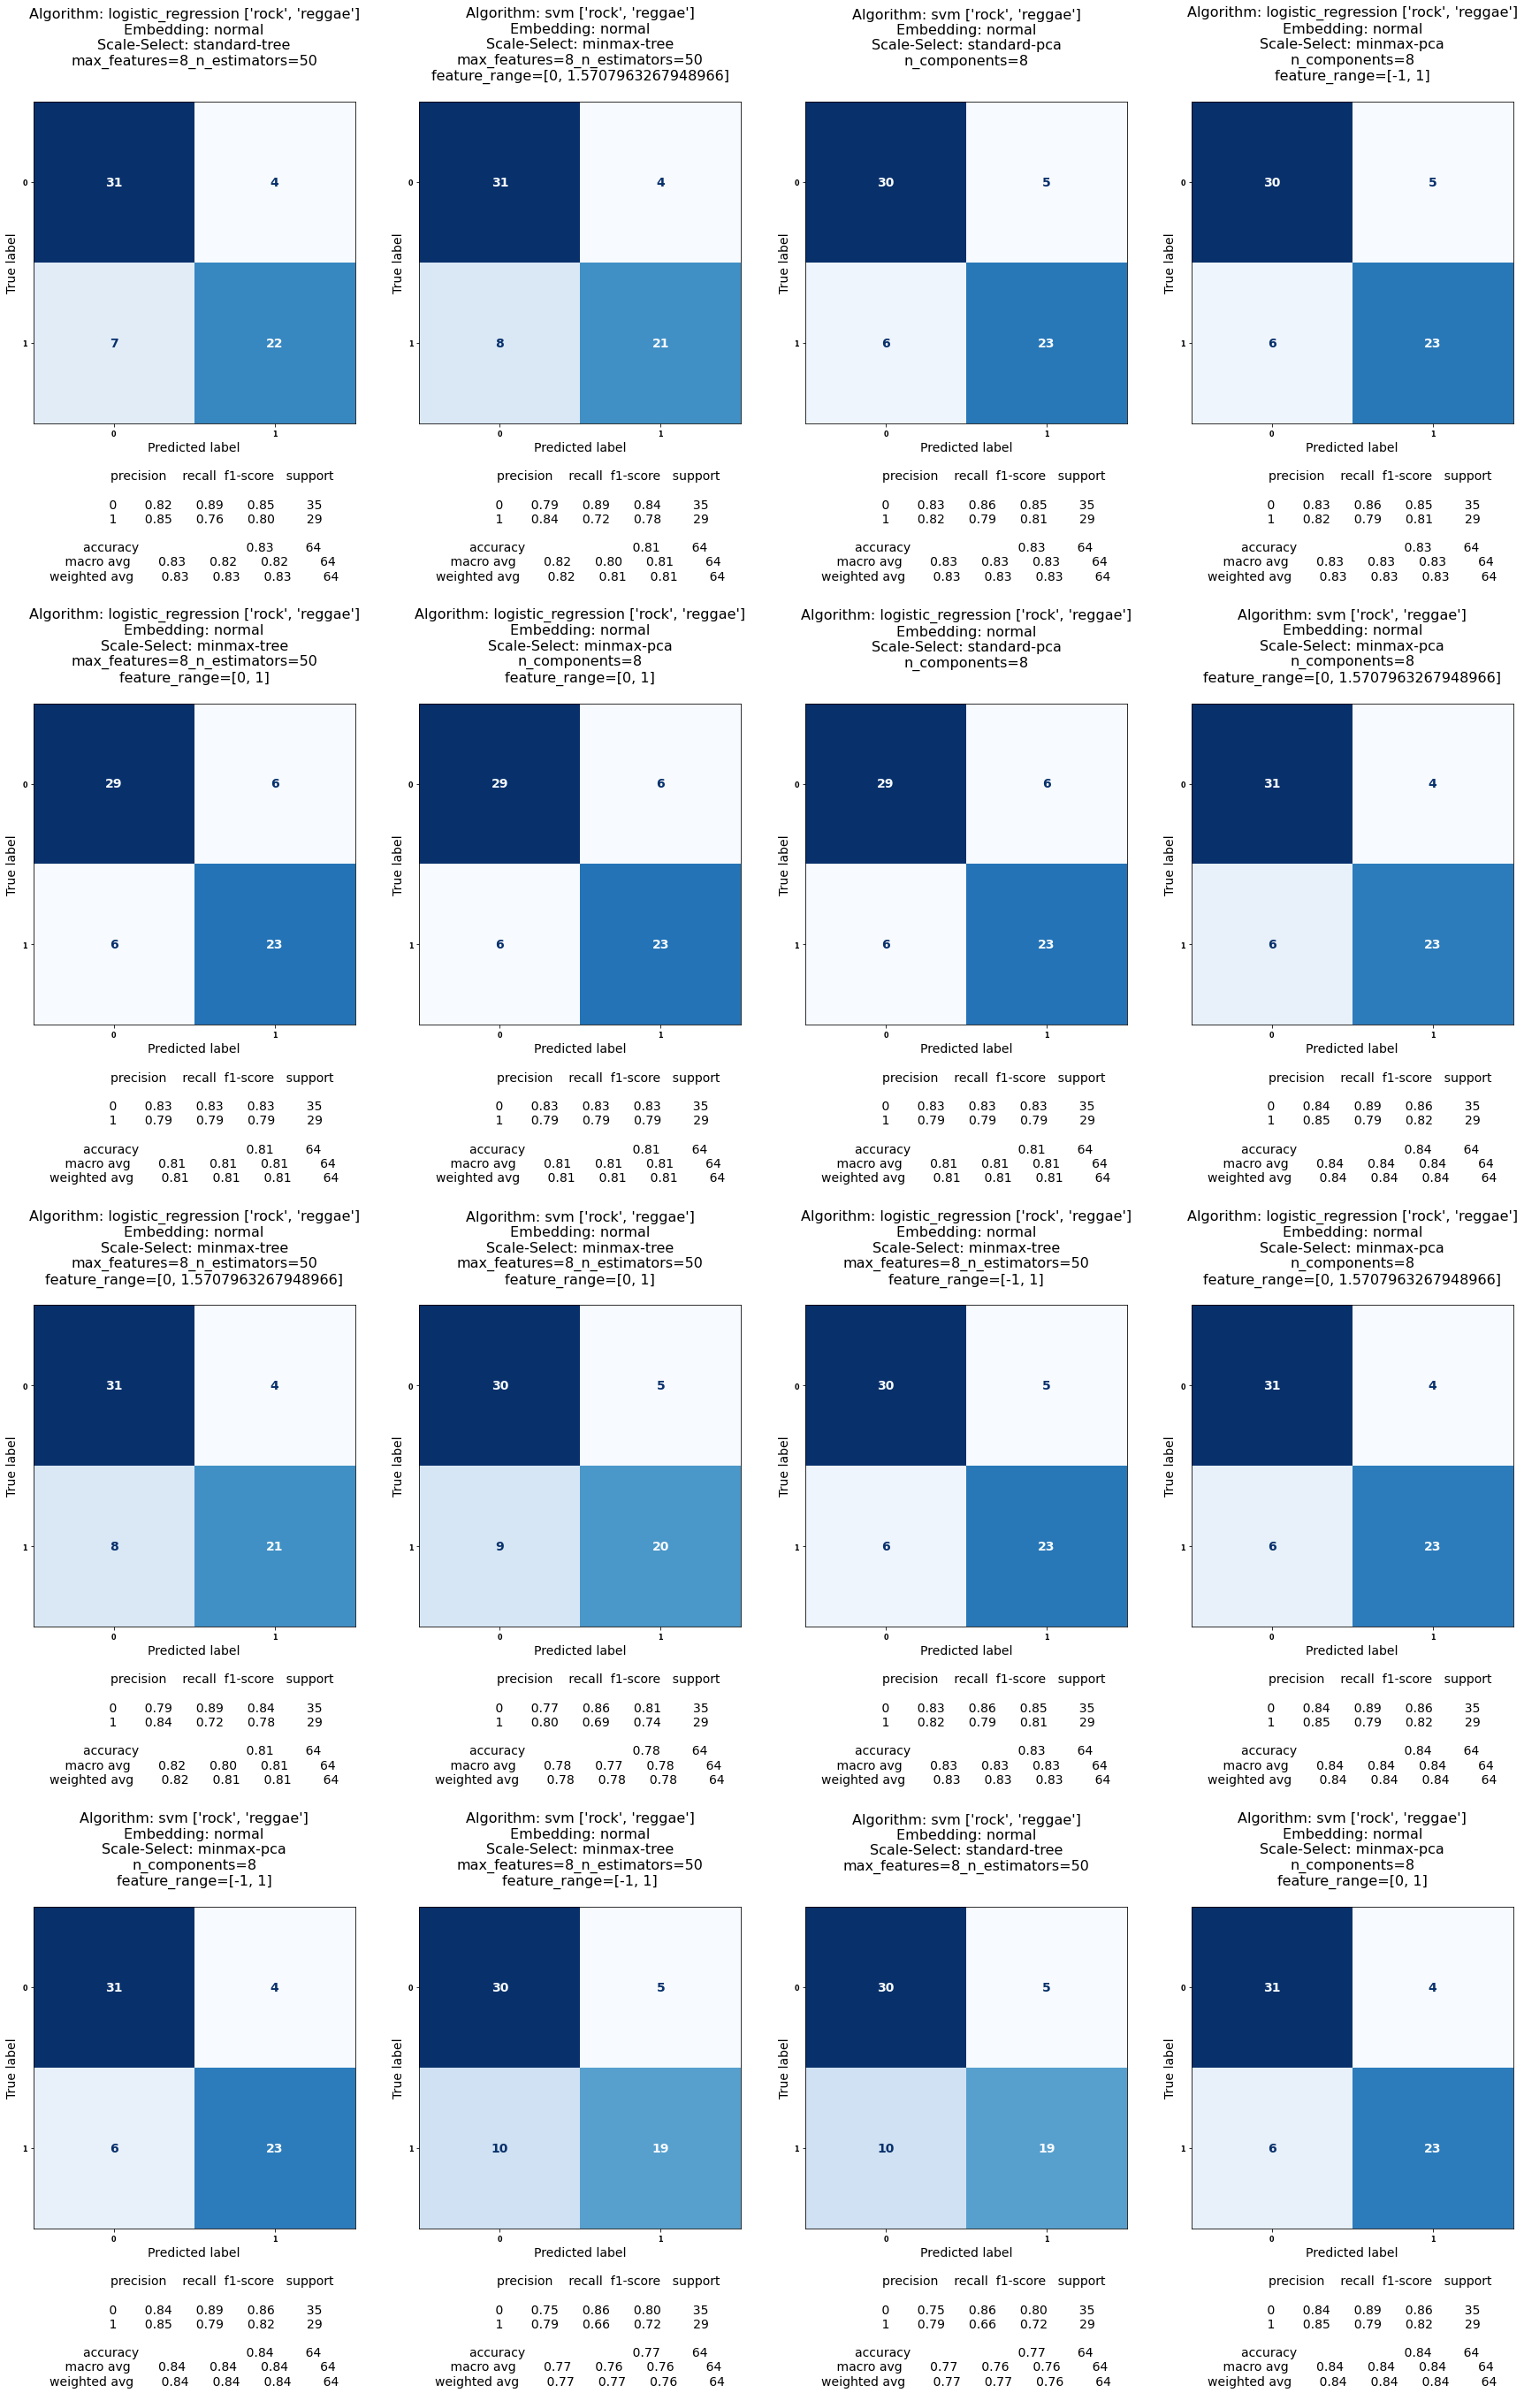

<Figure size 432x288 with 0 Axes>

In [338]:
%matplotlib inline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import matplotlib.pyplot as plt

# Customize matplotlib
SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

row_width = 30
row_height = 12
columns_in_row = 4
n_plots = len(filtered_results)
n_rows = int(np.ceil(n_plots / 4))
fig, axes = plt.subplots(n_rows, 4, figsize=(30, n_rows * row_height))
for result, i in zip(filtered_results, range(n_plots)):
    col = i % 4
    row = int(np.floor(i / 4))
    y_test_hat = result.y_test_hat
    clf = result.clf
    model_configuration = result.model_configuration
    samples_tfd = result.samples_tfd
    model_name = result.model_name

    display_report = classification_report(samples_tfd.y_test, y_test_hat)
    title_text = (
        f"Algorithm: {model_configuration.algorithm} {model_configuration.target_pair}\n"
        f"Embedding: {model_configuration.embedding_type}\n"
        f"Scale-Select: {model_configuration.scaler_method}-{model_configuration.selection_method}\n"
        f"{model_configuration.scaler_param_str}\n{model_configuration.selection_param_str}\n"
    )
    axes[row, col].grid(False)
    ConfusionMatrixDisplay.from_predictions(
        samples_tfd.y_test, y_test_hat, ax=axes[row, col], cmap=plt.cm.Blues
    )

    axes[row, col].set_title(title_text)
    axes[row, col].set_xlabel(f"Predicted label\n\n{display_report}")
    im = axes[row, col].images
    cb = im[-1].colorbar
    cb.remove()


plt.close()
plt.tight_layout()
fig